# MILESTONE 2

IMDB dataset + Siraj's Network

In [1]:
import numpy as np
import tensorflow as tf

## Preprocessing Dataset

1. Removing punctuations
2. Generating word_to_int map
3. Coverting each review in ints
4. Padding each review with 0's and generating input of length 200

In [2]:
import re
from collections import Counter
from nltk.corpus import stopwords

def preprocess(text):
    
    # Replace punctuation with tokens so we can use them in our model
    '''
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <PERIOD> ')
    text = text.replace('"', ' <PERIOD> ')
    text = text.replace(';', ' <PERIOD> ')
    text = text.replace('!', ' <PERIOD> ')
    text = text.replace('?', ' <PERIOD> ')
    text = text.replace('(', ' <PERIOD> ')
    text = text.replace(')', ' <PERIOD> ')
    text = text.replace('--', ' <PERIOD> ')
    text = text.replace('?', ' <PERIOD> ')
    '''
    text = text.replace('<br />', ' <PERIOD> ')
    text = text.replace('\\', ' <PERIOD> ')
    text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <PERIOD> ')
    text = text.replace(' <PERIOD> ', ' ')
    words = text.split()
    
    return words

def removing_noise(words):
    word_count = Counter(words)
    #stops = set(stopwords.words("english"))
    words_new = [word for word in words if (word_count[word]>5) #and (not word in stops)
                ]
    return words_new
    


In [3]:
import csv

filename = 'data/labeledTrainData.tsv'
review_ids = []
reviews = []
labels = []
#importing dataset into lists
wrong_temp = []
#[92, 102, 120, 259, 404, 1028, 1094, 1184, 1229, 1234, 1343, 1503, 1790, 1861, 2212, 3430, 3771, 3870, 4106, 4407, 4866, 5053, 5218, 5221, 5514, 5553, 5646, 5853, 6086, 6499, 6582, 6746, 7021, 7023, 7194, 7331, 7454, 7473, 7553, 7837, 8119, 8264, 8407, 8433, 8971, 9076, 9204, 9402, 9490, 9552, 9562, 9632, 9716, 9748, 9787, 10107, 10230, 10233, 10414, 10477, 10500, 10702, 10892, 11048, 11055, 11371, 11375, 11513, 11744, 11944, 12071, 12159, 12188, 12243, 12341, 12558, 12594, 12808, 13087, 13159, 14111, 14755, 14860, 14993, 15094, 15260, 15352, 15360, 15656, 15871, 16214, 16274, 16492, 16539, 16613, 16622, 16870, 16949, 16990, 16992, 17071, 17254, 17371, 17450, 17463, 17603, 17709, 17712, 17749, 18024, 18221, 18226, 18681, 18784, 18896, 19063, 19609, 19714, 19889]

with open(filename, 'r') as f:
    next(f)
    reader = csv.reader(f, delimiter='\t')
    row_count = 0
    for row in reader:
        review_ids.append(row[0])
        labels.append([int(row[1])] )
        reviews.append(row[2])

In [4]:
reviews_pp = []
words = []

for review in reviews:
    review_pp = preprocess(review)
    reviews_pp.append(review_pp)
    words.extend(review_pp)
    
words = removing_noise(words)

In [5]:
#Converting word to integers and making the vocabulary
vocab = set(words)
vocab_size = len(vocab)
words_count = Counter(words)
sorted_vocab = sorted(words_count, key = words_count.get, reverse = True)
word_to_int = {word:i for i,word in enumerate(sorted_vocab,1)}

#Converting each review in the form of integers
reviews_pp_ints = []
for review in reviews_pp:
    this_review_int = []
    for word in review:
        if word in vocab:
            this_review_int.append(word_to_int[word])
    reviews_pp_ints.append(this_review_int)

In [6]:
len(reviews_pp_ints[0])

412

In [7]:
len(reviews_pp[0])

429

In [8]:
len(reviews_pp_ints)

25000

In [9]:
max_seq_len = 200
features = np.zeros((len(reviews_pp_ints), max_seq_len), dtype=int)
for i, row in enumerate(reviews_pp_ints):
    features[i, :len(row)] = np.array(row[:max_seq_len] )

In [10]:
# 'features' is a 2d array storing all sequences

## Train Test Validation split

In [11]:
split_frac = 0.8
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

## Building Network

In [12]:
input_size = 300
embed_size = 100
lstm_size = 256
lstm_layers = 1
batch_size = 500
hidden_nodes = 10


X = tf.placeholder(tf.int32, [None, None], name = 'inputs')
Y = tf.placeholder(tf.float32, [None, 1], name = 'labels')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

tf.set_random_seed(5)

embedding = tf.Variable(tf.random_uniform((vocab_size+1, embed_size), -1, 1))
embed = tf.nn.embedding_lookup(embedding, X)

lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)

cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layers)

#getting an initial state of zeros\n",
initial_state = cell.zero_state(batch_size, tf.float32)

outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state = initial_state)

#hidden_layer = tf.contrib.layers.fully_connected(outputs[:, -1], hidden_nodes, activation_fn=tf.nn.relu)
predictions = tf.contrib.layers.fully_connected(outputs[:, -1],1, activation_fn=tf.sigmoid)
#predictions,Y\n",

loss = tf.reduce_mean(tf.square(Y - predictions))
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

In [13]:
#Accuracy:
correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.float32), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training

In [14]:
n_epochs = 60

In [15]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
global_train_acc = []
global_test_acc = []

global_train_loss = []
global_test_loss = []
import time
start_time = time.time()
for e in range(n_epochs):
    state = sess.run(initial_state)
    iteration = 1
    loss_=0.0
    temp_train_loss = []
    for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
        feed = {X: x, Y: y, initial_state: state, keep_prob: 0.5}

        state, loss_,  _ = sess.run([final_state, loss, optimizer], feed_dict=feed)

        if iteration%5==0:
            print("Epoch: {}/{}".format(e, n_epochs),
                  "Iteration: {}".format(iteration),
                  "Train loss: {:.5f}".format(loss_))
        temp_train_loss.append(loss_)
        '''
        if iteration%25==0:
            val_acc = []
            val_state = sess.run(cell.zero_state(batch_size, tf.float32))
            for x, y in get_batches(val_x, val_y, batch_size):
                feed = {X: x,
                        Y: y,
                        initial_state: val_state}
                batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                val_acc.append(batch_acc)
            print("Val acc: {:.5f}".format(np.mean(val_acc)))
        '''
        '''
        if iteration%25==0:
            # train Acc calculation
            train_acc = []
            train_state = sess.run(cell.zero_state(batch_size, tf.float32))
            for x, y in get_batches(train_x, train_y, batch_size):
                feed = {X: x,
                        Y: y,
                        initial_state: train_state}
                batch_acc, train_state, corr = sess.run([accuracy, final_state, correct_pred], feed_dict=feed)
                bad_indexes = [index for index, correctness in enumerate(corr) if correctness ==0 ]
                train_acc.append(batch_acc)
            print("Train acc: {:.5f}".format(np.mean(train_acc)))
            global_train_acc.append(np.mean(train_acc))
            
            # test acc calculation
            test_acc = []
            test_state = sess.run(cell.zero_state(batch_size, tf.float32))
            for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
                feed = {X: x,Y: y,initial_state: test_state}

                batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
                test_acc.append(batch_acc)
            print("Train acc: {:.5f}".format(np.mean(test_acc)))
            global_test_acc.append(np.mean(test_acc))
        '''    
        iteration +=1    
    global_train_loss.append(np.mean(temp_train_loss))
    
    temp_test_loss = []
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {X: x,Y: y,initial_state: test_state,  keep_prob: 1}

        batch_acc, test_state, loss_ = sess.run([accuracy, final_state, loss], feed_dict=feed)
        temp_test_loss.append(loss_)
    
    global_test_loss.append(np.mean(temp_test_loss))
    
    
    
print('Training Completed')
print('Total Time Taken: '+str(time.time()-start_time)+' sec' )

Epoch: 0/60 Iteration: 5 Train loss: 0.37086
Epoch: 0/60 Iteration: 10 Train loss: 0.26400
Epoch: 0/60 Iteration: 15 Train loss: 0.26513
Epoch: 0/60 Iteration: 20 Train loss: 0.25516
Epoch: 0/60 Iteration: 25 Train loss: 0.26013
Epoch: 0/60 Iteration: 30 Train loss: 0.25427
Epoch: 0/60 Iteration: 35 Train loss: 0.25255
Epoch: 0/60 Iteration: 40 Train loss: 0.24954
Epoch: 1/60 Iteration: 5 Train loss: 0.24722
Epoch: 1/60 Iteration: 10 Train loss: 0.24471
Epoch: 1/60 Iteration: 15 Train loss: 0.25265
Epoch: 1/60 Iteration: 20 Train loss: 0.24892
Epoch: 1/60 Iteration: 25 Train loss: 0.24557
Epoch: 1/60 Iteration: 30 Train loss: 0.24174
Epoch: 1/60 Iteration: 35 Train loss: 0.24362
Epoch: 1/60 Iteration: 40 Train loss: 0.24137
Epoch: 2/60 Iteration: 5 Train loss: 0.24189
Epoch: 2/60 Iteration: 10 Train loss: 0.23771
Epoch: 2/60 Iteration: 15 Train loss: 0.23725
Epoch: 2/60 Iteration: 20 Train loss: 0.22959
Epoch: 2/60 Iteration: 25 Train loss: 0.22247
Epoch: 2/60 Iteration: 30 Train loss:

Epoch: 22/60 Iteration: 10 Train loss: 0.01045
Epoch: 22/60 Iteration: 15 Train loss: 0.01387
Epoch: 22/60 Iteration: 20 Train loss: 0.01337
Epoch: 22/60 Iteration: 25 Train loss: 0.00240
Epoch: 22/60 Iteration: 30 Train loss: 0.00616
Epoch: 22/60 Iteration: 35 Train loss: 0.01071
Epoch: 22/60 Iteration: 40 Train loss: 0.01181
Epoch: 23/60 Iteration: 5 Train loss: 0.00213
Epoch: 23/60 Iteration: 10 Train loss: 0.00999
Epoch: 23/60 Iteration: 15 Train loss: 0.00995
Epoch: 23/60 Iteration: 20 Train loss: 0.01387
Epoch: 23/60 Iteration: 25 Train loss: 0.00208
Epoch: 23/60 Iteration: 30 Train loss: 0.00803
Epoch: 23/60 Iteration: 35 Train loss: 0.00802
Epoch: 23/60 Iteration: 40 Train loss: 0.01188
Epoch: 24/60 Iteration: 5 Train loss: 0.00203
Epoch: 24/60 Iteration: 10 Train loss: 0.01080
Epoch: 24/60 Iteration: 15 Train loss: 0.01152
Epoch: 24/60 Iteration: 20 Train loss: 0.01090
Epoch: 24/60 Iteration: 25 Train loss: 0.00580
Epoch: 24/60 Iteration: 30 Train loss: 0.00617
Epoch: 24/60 It

Epoch: 44/60 Iteration: 5 Train loss: 0.00424
Epoch: 44/60 Iteration: 10 Train loss: 0.00690
Epoch: 44/60 Iteration: 15 Train loss: 0.01074
Epoch: 44/60 Iteration: 20 Train loss: 0.01037
Epoch: 44/60 Iteration: 25 Train loss: 0.00943
Epoch: 44/60 Iteration: 30 Train loss: 0.00921
Epoch: 44/60 Iteration: 35 Train loss: 0.00857
Epoch: 44/60 Iteration: 40 Train loss: 0.00947
Epoch: 45/60 Iteration: 5 Train loss: 0.00393
Epoch: 45/60 Iteration: 10 Train loss: 0.00925
Epoch: 45/60 Iteration: 15 Train loss: 0.00993
Epoch: 45/60 Iteration: 20 Train loss: 0.01069
Epoch: 45/60 Iteration: 25 Train loss: 0.01130
Epoch: 45/60 Iteration: 30 Train loss: 0.01192
Epoch: 45/60 Iteration: 35 Train loss: 0.00796
Epoch: 45/60 Iteration: 40 Train loss: 0.01454
Epoch: 46/60 Iteration: 5 Train loss: 0.00418
Epoch: 46/60 Iteration: 10 Train loss: 0.00765
Epoch: 46/60 Iteration: 15 Train loss: 0.00945
Epoch: 46/60 Iteration: 20 Train loss: 0.00820
Epoch: 46/60 Iteration: 25 Train loss: 0.01192
Epoch: 46/60 Ite

In [19]:
test_acc = []
test_state = sess.run(cell.zero_state(batch_size, tf.float32))
for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
    feed = {X: x,Y: y,initial_state: test_state, keep_prob: 1}

    batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
    test_acc.append(batch_acc)
print("Train acc: {:.5f}".format(np.mean(test_acc)))

Train acc: 0.77320


In [ ]:
wrong_temp = [92, 282, 1184, 2331, 2815, 2848, 3233, 4833, 7077, 7713, 7837, 8724, 9364, 10162, 10477, 12243, 14445, 15076, 18896, 19741, 19895]
for i in wrong_temp[:]:
    print('#'+str(i))
    print(reviews[i])
    print('-->Label='+str(labels[i]))
    print()
    print()

In [ ]:
max_l = 0
min_l = 10000
i = 0
m = -1
for review in reviews_pp_ints:
    if len(review) > max_l:
        max_l = len(review)
    if len(review) < min_l:
        min_l = len(review)
        m = i
    i += 1
reviews[m], m, labels[m]

In [ ]:
words_count['terrible']

In [ ]:
words_count['horror']

In [ ]:
a = [92, 282, 1184, 2331, 2815, 2848, 3233, 4833, 7077, 7713, 7837, 8724, 9364, 10162, 10477, 12243, 14445, 15076, 18896, 19741, 19895]
len(a)

## Scores of Bad Indices

In [ ]:
'''
for index in a:
    state = sess.run(initial_state)

    feed = {X: features[index].reshape(1,None) , Y: labels[index].reshape(1,None), initial_state: state}

        outputs_ = sess.run([outputs], feed_dict=feed)

    print("Index:() ".format(index))
    print("Prediction:{} ".format(outputs_))
'''

## Training - Test Curve

In [20]:
print(len(global_train_loss))
print(global_test_loss)

60
[0.24922124, 0.25225767, 0.26149547, 0.21638498, 0.24500819, 0.17880425, 0.17892753, 0.17332494, 0.19193126, 0.18435828, 0.21163031, 0.18992403, 0.22238441, 0.23674056, 0.21342954, 0.18122981, 0.1857585, 0.18011074, 0.17807364, 0.18085107, 0.19068667, 0.18928155, 0.1868103, 0.19152905, 0.19835865, 0.19998671, 0.19163567, 0.18537682, 0.18401535, 0.18884964, 0.18799414, 0.18801431, 0.19316795, 0.19291928, 0.19363555, 0.18716188, 0.18127254, 0.18426366, 0.18542771, 0.18857479, 0.19288965, 0.21306169, 0.20296955, 0.19056414, 0.19578031, 0.18438628, 0.19013104, 0.20042448, 0.1848968, 0.19388637, 0.1935045, 0.19468983, 0.19723199, 0.19126642, 0.19377334, 0.1918561, 0.20972607, 0.20698555, 0.20821933, 0.20876786]


In [ ]:
for i in range( len(global_train_acc) ):
    global_train_acc[i] /=100
    global_test_acc[i] /=100
    

[0.27646422, 0.24479373, 0.22284818, 0.18224433, 0.15579242, 0.12269354, 0.09203776, 0.059525914, 0.046631362, 0.041203648, 0.032414231, 0.027642328, 0.022105936, 0.022394991, 0.04220327, 0.023677845, 0.022866067, 0.017994663, 0.012210284, 0.009390913, 0.0083699273, 0.00780555, 0.0079420935, 0.0073836399, 0.008408444, 0.0077077784, 0.0069472282, 0.0067242966, 0.0060860207, 0.0059851394, 0.0071866424, 0.0068035526, 0.0065412819, 0.0061423429, 0.0067196437, 0.0064841295, 0.0063723801, 0.0056546987, 0.0066828071, 0.0064398311, 0.0066907229, 0.0087283561, 0.010279352, 0.0087473588, 0.0079336688, 0.0078925882, 0.0079951929, 0.0077134296, 0.0068428009, 0.0053863726, 0.0058005541, 0.0053988015, 0.0045242789, 0.0055676373, 0.005387472, 0.0051520737, 0.0049751275, 0.0054307943, 0.0062456289, 0.0073672654]
[0.24922124, 0.25225767, 0.26149547, 0.21638498, 0.24500819, 0.17880425, 0.17892753, 0.17332494, 0.19193126, 0.18435828, 0.21163031, 0.18992403, 0.22238441, 0.23674056, 0.21342954, 0.18122981,

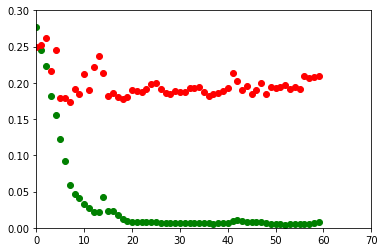

Minimum Testing Loss: 0.173325


In [21]:
print(global_train_loss)
print(global_test_loss)
import matplotlib.pyplot as plt
%matplotlib inline 
plt.ion()
x = range(60) 
plt.axis([0,70,0,0.3])
plt.plot(x,global_train_loss,'go',x,global_test_loss,'ro')
plt.show()

print('Minimum Testing Loss: '+str(np.min(global_test_loss)) )

In [ ]:
print(reviews[92])